# Movies-Script Data Analysis #

# Group No. 5 #
## Group Members: 
### Benjamin Joseph(101806)
### Geoferry Michael(101818)
### Eshan Goel(101820)
### Pranay Gupta(101824)
### Jason Felix(101828)
### Sanmith Kurian(101836)


## Technology Used ##
### MongoDB, MatplotLib, Seaborn, WordCloud, NLTK, NumPy, Pandas, IMBLearn ###


In [2]:
# pip install imblearn

### Adding Data to MongoDB

In [3]:
import numpy as np 
import pandas as pd
from pymongo import MongoClient
import json

episodeIV = pd.read_csv('./SW_EpisodeIV.txt', delim_whitespace=True, names=["index","character","dialogue"] ,header = None)
episodeV = pd.read_csv('./SW_EpisodeV.txt', delim_whitespace=True, names=["index","character","dialogue"] ,header = None)
episodeVI = pd.read_csv('./SW_EpisodeVI.txt', delim_whitespace=True, names=["index","character","dialogue"] ,header = None)


client = MongoClient()
db = client['star_wars']
movies = db['movies']

recordsIV = json.loads(episodeIV.T.to_json()).values()
movies.insert_many(recordsIV)
recordsV = json.loads(episodeV.T.to_json()).values()
movies.insert_many(recordsV)
recordsVI = json.loads(episodeVI.T.to_json()).values()
movies.insert_many(recordsVI)
print(str(movies.count_documents({}))+' entries inserted!')

5052 entries inserted!


### Importing Libraries ###

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

import nltk
import nltk
# nltk.download('wordnet')
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
from collections import Counter
from wordcloud import WordCloud
from ast import literal_eval

### Importing Data from MongoDB ###

In [5]:
# from pymongo import MongoClient
client = MongoClient()
client.list_database_names()
star_wars = client['star_wars']
star_wars.list_collection_names()
cursor = star_wars['movies'].find({})
dialogues = pd.DataFrame(list(cursor))
dialogues = dialogues.replace('None', np.nan).dropna()

In [6]:
dialogues

,_id,index,character,dialogue
1,615ee1ed76d0d5668b107915,1,THREEPIO,Did you hear that? They've shut down the main...
2,615ee1ed76d0d5668b107916,2,THREEPIO,We're doomed!
3,615ee1ed76d0d5668b107917,3,THREEPIO,There'll be no escape for the Princess this time.
4,615ee1ed76d0d5668b107918,4,THREEPIO,What's that?
5,615ee1ed76d0d5668b107919,5,THREEPIO,I should have known better than to trust the l...
...,...,...,...,...
5047,615f1d9f8f70fc19d362ecd8,670,LANDO,"Wedge, I don't think we're going to make it."
5048,615f1d9f8f70fc19d362ecd9,671,WEDGE,You'll make it. Just follow me Gold Leader.
5049,615f1d9f8f70fc19d362ecda,672,LANDO,I promised to return his ship without a scratc...
5050,615f1d9f8f70fc19d362ecdb,673,HAN,Lando...


In [7]:
dialogues.head()

,_id,index,character,dialogue
1,615ee1ed76d0d5668b107915,1,THREEPIO,Did you hear that? They've shut down the main...
2,615ee1ed76d0d5668b107916,2,THREEPIO,We're doomed!
3,615ee1ed76d0d5668b107917,3,THREEPIO,There'll be no escape for the Princess this time.
4,615ee1ed76d0d5668b107918,4,THREEPIO,What's that?
5,615ee1ed76d0d5668b107919,5,THREEPIO,I should have known better than to trust the l...


### Mapping Data ###

In [8]:
dialogues['dialogue_wordcount'] = dialogues['dialogue'].map(lambda x:len(re.findall(r'\w+', x)))

In [9]:
total_char_words = dialogues.groupby('character', as_index=False).dialogue_wordcount.sum()
total_char_words = pd.DataFrame(total_char_words)
total_char_words

,character,dialogue_wordcount
0,ACKBAR,430
1,ANAKIN,42
2,ANNOUNCER,34
3,ASSISTANT OFFICER,22
4,ASTRO-OFFICER,36
...,...,...
124,WOMAN,16
125,WOMAN CONTROLLER,10
126,Y-WING PILOT,6
127,YODA,1644


### Reduced Data ###

In [10]:
dialogues['character'].value_counts()

LUKE                988
HAN                 918
THREEPIO            602
LEIA                454
VADER               280
                   ... 
IMPERIAL SOLDIER      2
PILOTS                2
HOBBIE                2
PORKINS               2
RED TWO               2
Name: character, Length: 129, dtype: int64

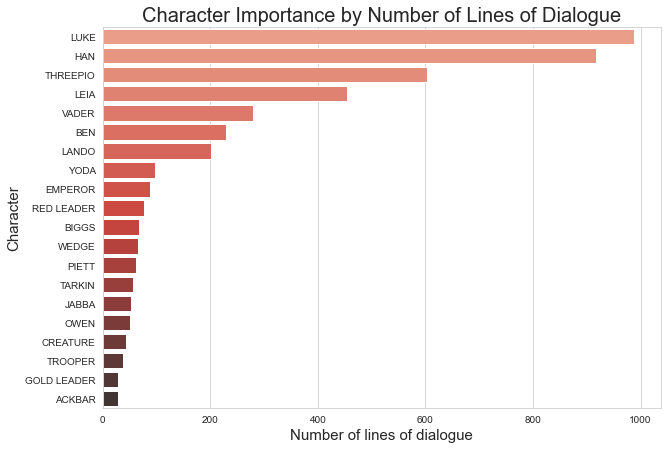

In [11]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,7))
sns.countplot(y='character', data=dialogues, order=dialogues.character.value_counts().iloc[:20].index, palette="Reds_d")
plt.xlabel('Number of lines of dialogue', fontsize=15)
plt.ylabel('Character', fontsize=15)
plt.title('Character Importance by Number of Lines of Dialogue', fontsize=20)
plt.show()

Text(0.5, 1.0, 'Character Importance by Number of Words of Dialogue')

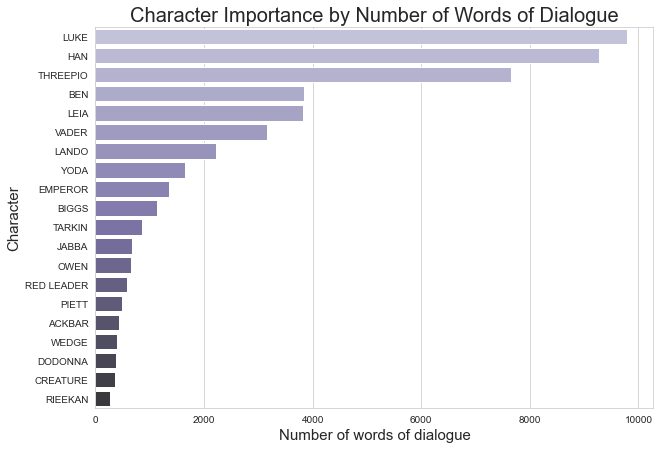

In [12]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,7))
sns.barplot(x='dialogue_wordcount',y='character', data=total_char_words, palette="Purples_d", order=total_char_words.sort_values('dialogue_wordcount', ascending=False).character[0:20], orient='h')
plt.xlabel('Number of words of dialogue', fontsize=15)
plt.ylabel('Character', fontsize=15)
plt.title('Character Importance by Number of Words of Dialogue', fontsize=20)

### Word Analysis ###

In [13]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence = sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url = re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words = [PorterStemmer().stem(w) for w in filtered_words]
    lemma_words=[WordNetLemmatizer().lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)

In [14]:
dialogues['cleanText']=dialogues['dialogue'].map(lambda x:preprocess(x))

Text(0.5, 1.0, 'Common words')

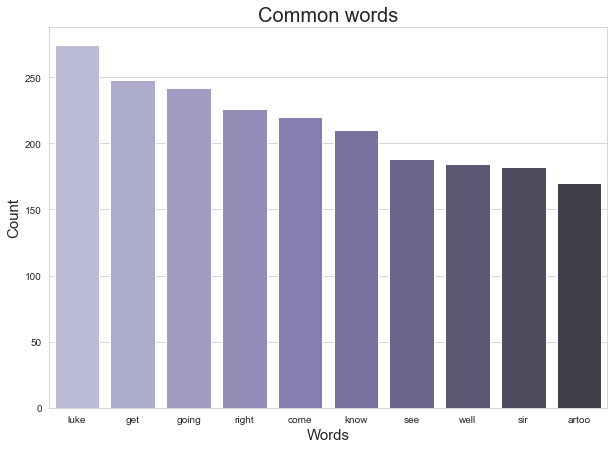

In [15]:
common_words = Counter(" ".join(dialogues["cleanText"]).split()).most_common(10)
sns.set_style('whitegrid')
plt.figure(figsize=(10,7))
sns.barplot(x=[x[0] for x in common_words], y=[x[1] for x in common_words], palette="Purples_d")
plt.xlabel('Words', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Common words', fontsize=20)

In [16]:
luke = dialogues[dialogues['character']=='LUKE']

Text(0.5, 1.0, 'Luke')

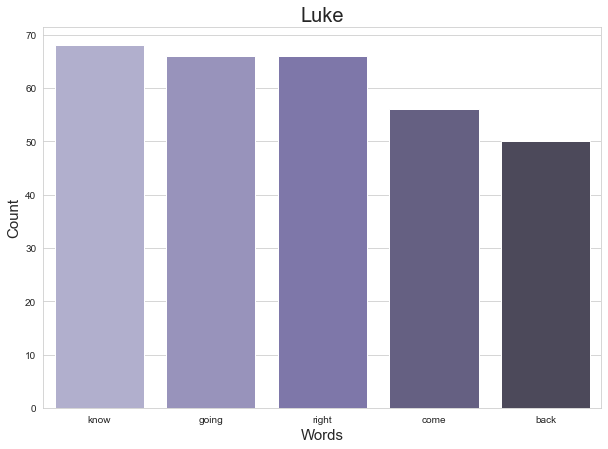

In [17]:
common_luke = Counter(" ".join(luke["cleanText"]).split()).most_common(5)
sns.set_style('whitegrid')
plt.figure(figsize=(10,7))
sns.barplot(x=[x[0] for x in common_luke], y=[x[1] for x in common_luke], palette="Purples_d")
plt.xlabel('Words', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Luke', fontsize=20)

In [18]:
han = dialogues[dialogues['character']=='HAN']

Text(0.5, 1.0, 'Han')

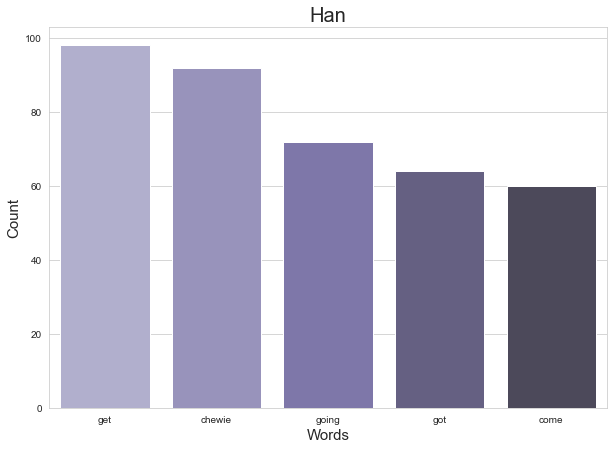

In [19]:
common_han = Counter(" ".join(han["cleanText"]).split()).most_common(5)
sns.set_style('whitegrid')
plt.figure(figsize=(10,7))
sns.barplot(x=[x[0] for x in common_han], y=[x[1] for x in common_han], palette="Purples_d")
plt.xlabel('Words', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Han', fontsize=20)

In [20]:
pio = dialogues[dialogues['character']=='THREEPIO']

Text(0.5, 1.0, 'THREEPIO')

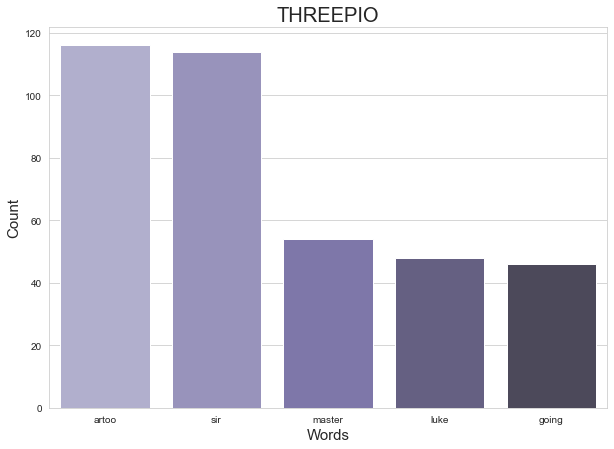

In [21]:
common_pio = Counter(" ".join(pio["cleanText"]).split()).most_common(5)
sns.set_style('whitegrid')
plt.figure(figsize=(10,7))
sns.barplot(x=[x[0] for x in common_pio], y=[x[1] for x in common_pio], palette="Purples_d")
plt.xlabel('Words', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('THREEPIO', fontsize=20)

### WordClouds ###

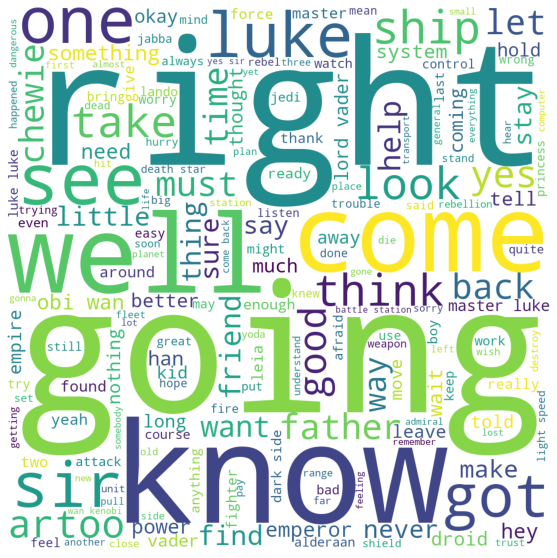

In [22]:
#Wordcloud for all movie dialogues
text = " ".join(line for line in dialogues["cleanText"])
wordcloud = WordCloud(width=1000, height=1000, background_color="white", min_font_size=15).generate(text)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

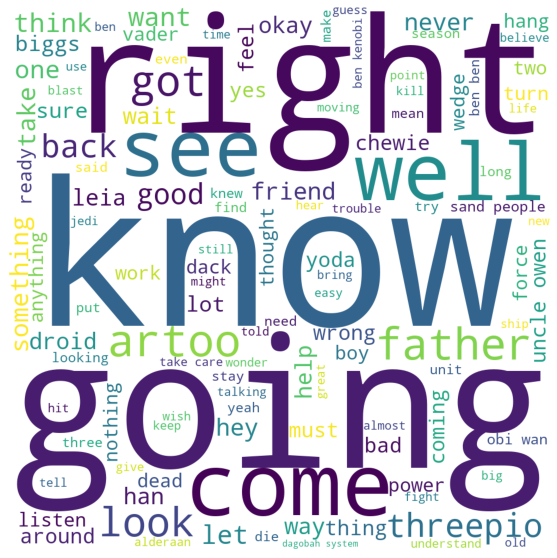

In [23]:
# wordcloud for luke skywalker
luke_text = " ".join(line for line in luke["cleanText"])
wordcloud = WordCloud(width=1000, height=1000, background_color="white", min_font_size=15).generate(luke_text)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

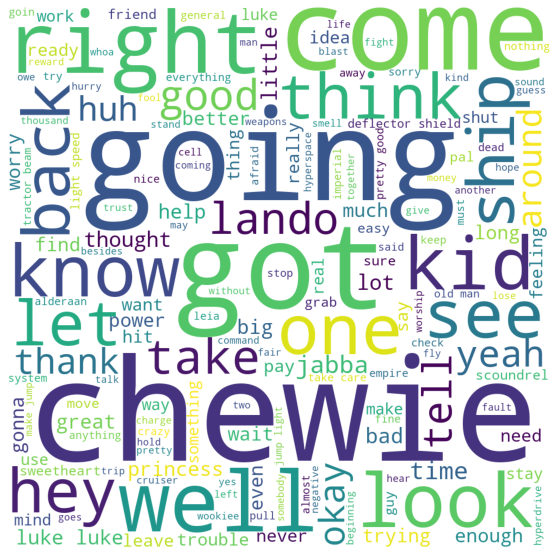

In [24]:
# wordcloud for han solo
han_text = " ".join(line for line in han["cleanText"])
wordcloud = WordCloud(width=1000, height=1000, background_color="white", min_font_size=15).generate(han_text)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

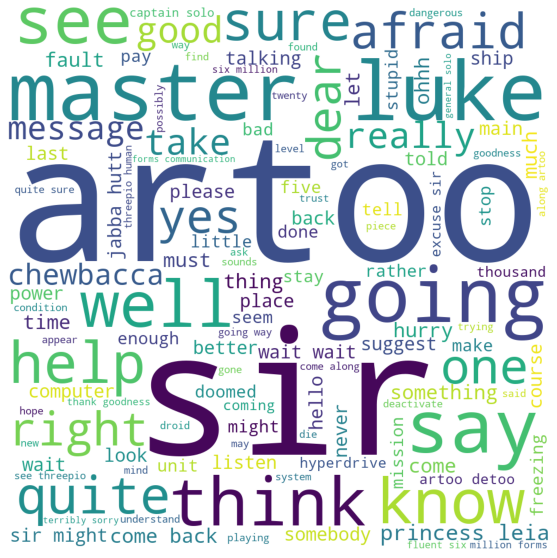

In [25]:
# wordcloud for threepio
pio_text = " ".join(line for line in pio["cleanText"])
wordcloud = WordCloud(width=1000, height=1000, background_color="white", min_font_size=15).generate(pio_text)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Future Scope ##